# 第12章: 高度なトピック

## 学習目標
- ネットワークフロー問題を解く
- グラフマッチングを理解する
- 二部グラフの応用を学ぶ
- 大規模グラフの処理テクニックを習得する

## 難易度: 上級

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
import numpy as np
%matplotlib inline

---
## 12.1 ネットワークフロー

### 12.1.1 最大フロー問題

In [2]:
# フローネットワークの作成
G = nx.DiGraph()
G.add_edge('s', 'a', capacity=10)
G.add_edge('s', 'b', capacity=8)
G.add_edge('a', 'b', capacity=5)
G.add_edge('a', 'c', capacity=7)
G.add_edge('b', 'c', capacity=6)
G.add_edge('b', 'd', capacity=9)
G.add_edge('c', 't', capacity=10)
G.add_edge('d', 't', capacity=12)

In [3]:
# 最大フローの計算
flow_value, flow_dict = nx.maximum_flow(G, 's', 't')

print(f"=== 最大フロー ===")
print(f"最大フロー値: {flow_value}")
print("\n各エッジのフロー:")
for u, flows in flow_dict.items():
    for v, flow in flows.items():
        if flow > 0:
            capacity = G[u][v]['capacity']
            print(f"  {u} → {v}: {flow}/{capacity}")

=== 最大フロー ===
最大フロー値: 18

各エッジのフロー:
  s → a: 10/10
  s → b: 8/8
  a → b: 3/5
  a → c: 7/7
  b → c: 3/6
  b → d: 8/9
  c → t: 10/10
  d → t: 8/12


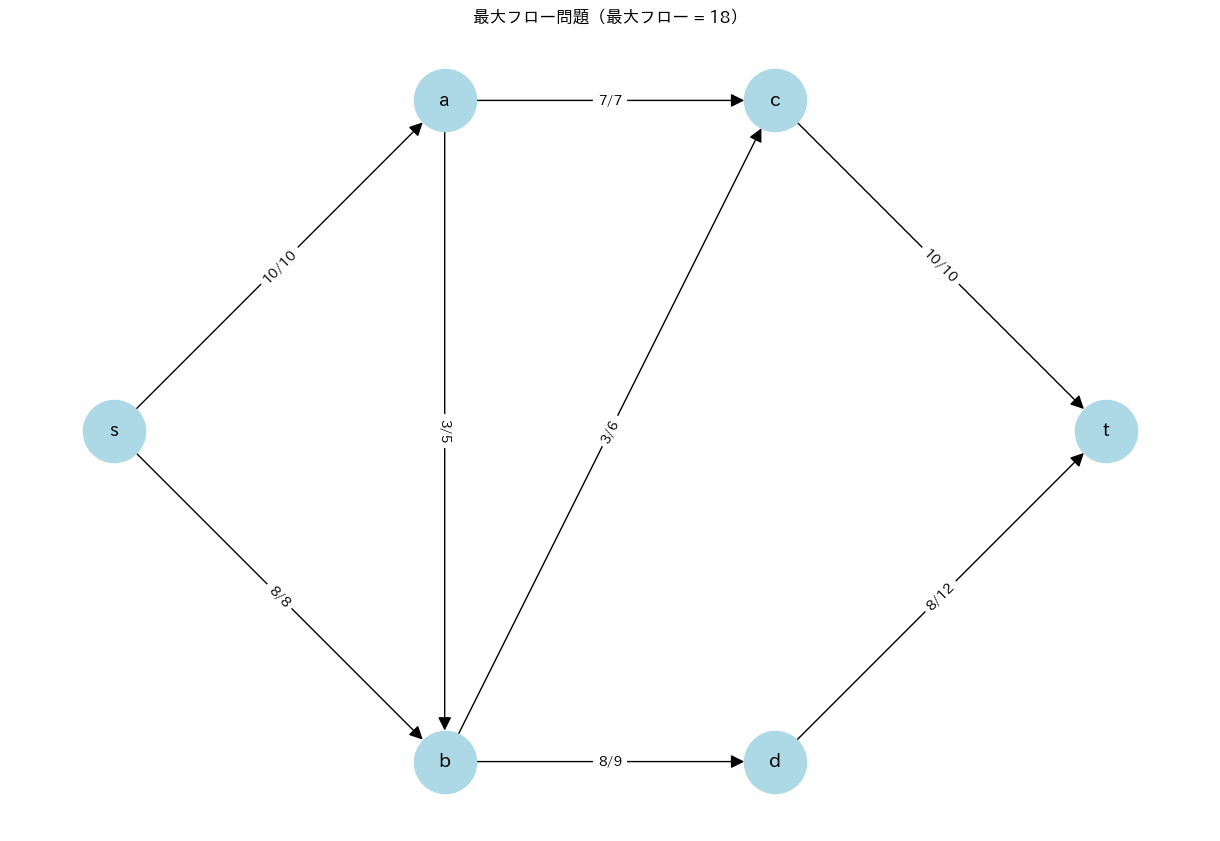

In [4]:
# 可視化
plt.figure(figsize=(12, 8))
pos = {
    's': (0, 1), 'a': (1, 2), 'b': (1, 0),
    'c': (2, 2), 'd': (2, 0), 't': (3, 1)
}

nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=2000, font_size=14, font_weight='bold', arrows=True, arrowsize=20)

# エッジラベル（フロー/容量）
edge_labels = {(u, v): f"{flow_dict[u][v]}/{G[u][v]['capacity']}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title(f"最大フロー問題（最大フロー = {flow_value}）")
plt.axis('off')
plt.show()

### 12.1.2 最小カット

In [5]:
# 最小カット
cut_value, partition = nx.minimum_cut(G, 's', 't')
reachable, non_reachable = partition

print(f"=== 最小カット ===")
print(f"カット値: {cut_value}（最大フローと等しい）")
print(f"ソース側: {reachable}")
print(f"シンク側: {non_reachable}")

=== 最小カット ===
カット値: 18（最大フローと等しい）
ソース側: {'s'}
シンク側: {'b', 'c', 'd', 't', 'a'}


In [6]:
# カットエッジを見つける
cut_edges = [(u, v) for u in reachable for v in non_reachable if G.has_edge(u, v)]
print(f"\nカットエッジ: {cut_edges}")


カットエッジ: [('s', 'b'), ('s', 'a')]


---
## 12.2 グラフマッチング

In [7]:
# マッチング問題
G = nx.Graph()
G.add_edges_from([
    (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (4, 5), (5, 6)
])

# 最大マッチング
matching = nx.max_weight_matching(G, maxcardinality=True)

print(f"=== 最大マッチング ===")
print(f"マッチング: {matching}")
print(f"サイズ: {len(matching)}")

=== 最大マッチング ===
マッチング: {(4, 2), (3, 1), (6, 5)}
サイズ: 3


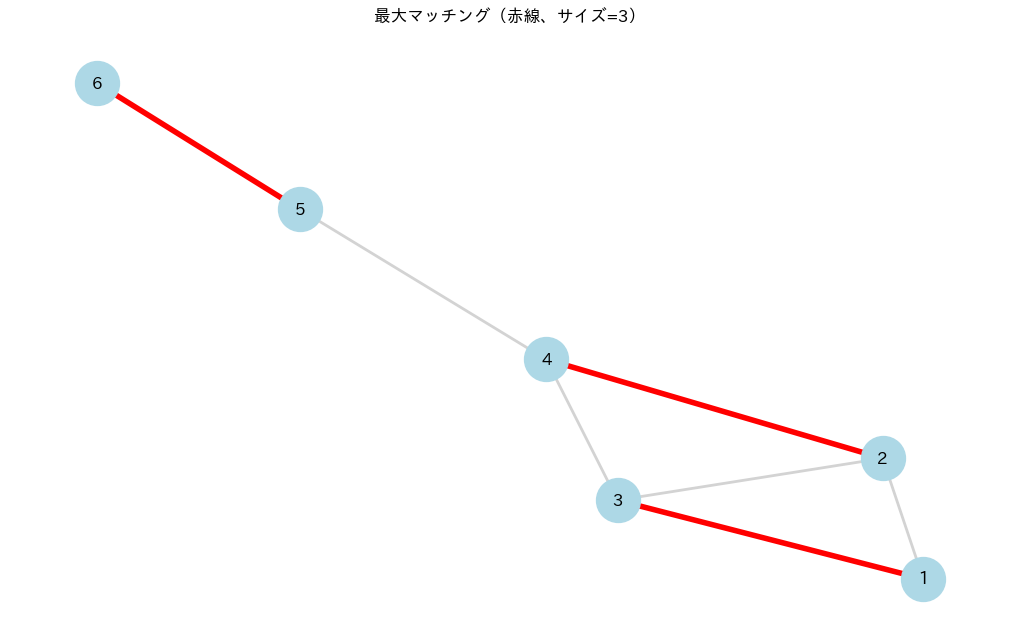

In [8]:
# 可視化
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=1000, font_size=12, edge_color='lightgray', width=2)

# マッチングエッジを強調
matching_edges = list(matching)
nx.draw_networkx_edges(G, pos, edgelist=matching_edges, edge_color='red', width=4)

plt.title(f"最大マッチング（赤線、サイズ={len(matching)}）")
plt.axis('off')
plt.show()

---
## 12.3 二部グラフの応用

In [9]:
# 二部グラフ（学生と科目の関係）
B = nx.Graph()

students = ['Alice', 'Bob', 'Charlie', 'Diana']
courses = ['Math', 'Physics', 'Chemistry', 'Biology']

B.add_nodes_from(students, bipartite=0)
B.add_nodes_from(courses, bipartite=1)

# 履修関係
B.add_edges_from([
    ('Alice', 'Math'), ('Alice', 'Physics'),
    ('Bob', 'Math'), ('Bob', 'Chemistry'),
    ('Charlie', 'Physics'), ('Charlie', 'Biology'),
    ('Diana', 'Chemistry'), ('Diana', 'Biology'), ('Diana', 'Math')
])

# 二部グラフか確認
print(f"二部グラフか: {nx.is_bipartite(B)}")

二部グラフか: True


In [10]:
# 二部グラフの最大マッチング
from networkx.algorithms import bipartite

matching = bipartite.maximum_matching(B, students)
print(f"\n最大マッチング: {len(matching)//2}ペア")
for s in students:
    if s in matching:
        print(f"  {s} → {matching[s]}")


最大マッチング: 4ペア
  Alice → Math
  Bob → Chemistry
  Charlie → Physics
  Diana → Biology


In [11]:
# 射影グラフ（学生間の関係）
student_projection = bipartite.projected_graph(B, students)

print(f"\n学生間ネットワーク（同じ科目を履修）:")
for u, v in student_projection.edges():
    # 共通科目を見つける
    common = set(B.neighbors(u)) & set(B.neighbors(v))
    print(f"  {u} - {v}: {common}")


学生間ネットワーク（同じ科目を履修）:
  Alice - Charlie: {'Physics'}
  Alice - Bob: {'Math'}
  Alice - Diana: {'Math'}
  Bob - Diana: {'Math', 'Chemistry'}
  Charlie - Diana: {'Biology'}


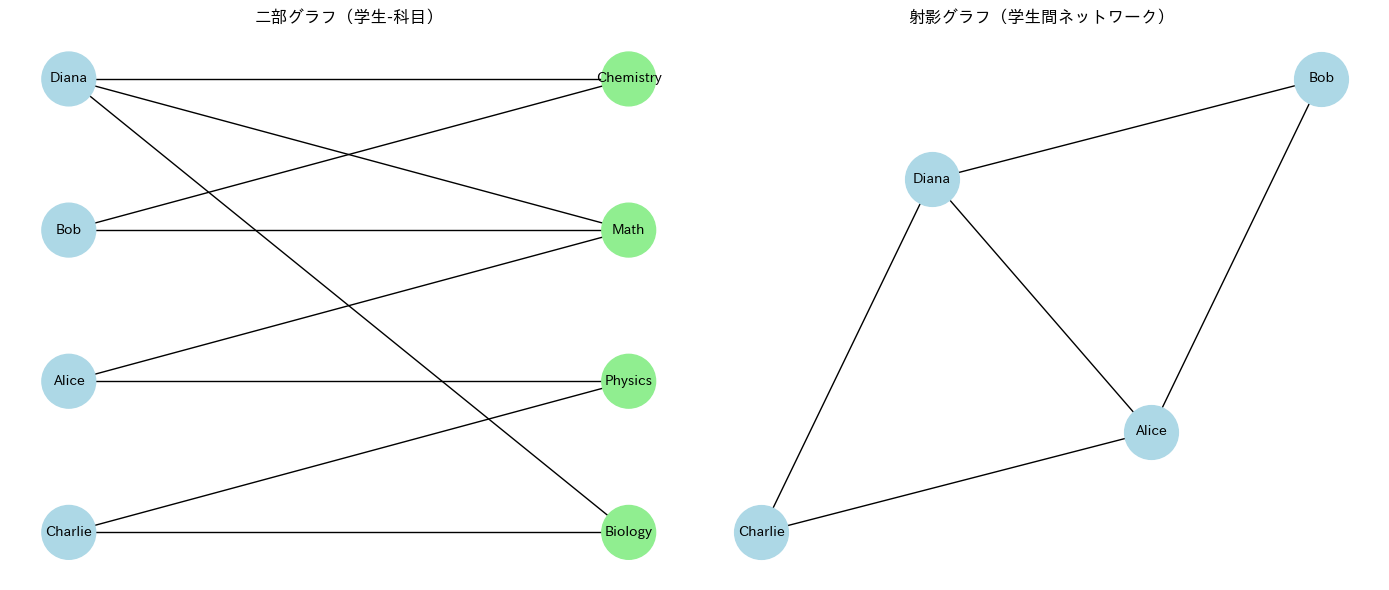

In [12]:
# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 二部グラフ
pos = nx.bipartite_layout(B, students)
colors = ['lightblue' if n in students else 'lightgreen' for n in B.nodes()]
nx.draw(B, pos, ax=axes[0], with_labels=True, node_color=colors, node_size=1500, font_size=10)
axes[0].set_title("二部グラフ（学生-科目）")

# 射影グラフ
pos2 = nx.spring_layout(student_projection, seed=42)
nx.draw(student_projection, pos2, ax=axes[1], with_labels=True,
        node_color='lightblue', node_size=1500, font_size=10)
axes[1].set_title("射影グラフ（学生間ネットワーク）")

plt.tight_layout()
plt.show()

---
## 12.4 グラフ同型性

In [13]:
# 2つのグラフが同型か確認
G1 = nx.cycle_graph(5)
G2 = nx.Graph([(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)])  # 同じ構造
G3 = nx.star_graph(4)  # 異なる構造

print(f"G1とG2は同型か: {nx.is_isomorphic(G1, G2)}")
print(f"G1とG3は同型か: {nx.is_isomorphic(G1, G3)}")

G1とG2は同型か: True
G1とG3は同型か: False


In [14]:
# 部分グラフ同型
G_large = nx.complete_graph(6)
G_small = nx.complete_graph(3)

# G_largeの中にG_smallと同型な部分グラフがあるか
from networkx.algorithms import isomorphism

GM = isomorphism.GraphMatcher(G_large, G_small)
print(f"\n部分グラフ同型が存在: {GM.subgraph_is_isomorphic()}")

# マッピングを取得
for mapping in list(GM.subgraph_isomorphisms_iter())[:3]:
    print(f"  マッピング: {mapping}")


部分グラフ同型が存在: True
  マッピング: {0: 0, 1: 1, 2: 2}
  マッピング: {0: 0, 1: 1, 3: 2}
  マッピング: {0: 0, 1: 1, 4: 2}


---
## 12.5 大規模グラフの処理

In [15]:
# 大規模グラフの生成
import time

n = 10000
m = 5

start = time.time()
G_large = nx.barabasi_albert_graph(n, m, seed=42)
elapsed = time.time() - start

print(f"=== 大規模グラフ ===")
print(f"ノード数: {G_large.number_of_nodes():,}")
print(f"エッジ数: {G_large.number_of_edges():,}")
print(f"生成時間: {elapsed:.3f}秒")

=== 大規模グラフ ===
ノード数: 10,000
エッジ数: 49,975
生成時間: 0.146秒


In [16]:
# 効率的な計算（サンプリング）
start = time.time()

# 近似媒介中心性（サンプリングベース）
approx_betweenness = nx.betweenness_centrality(G_large, k=100)  # k個のノードのみ使用

elapsed = time.time() - start
print(f"\n近似媒介中心性の計算時間: {elapsed:.3f}秒")
print(f"上位5ノード: {sorted(approx_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]}")


近似媒介中心性の計算時間: 3.629秒
上位5ノード: [(7, 0.08985843978864332), (9, 0.08264983443238844), (8, 0.07797171932300165), (0, 0.07114282618857677), (11, 0.04264786437759449)]


In [17]:
# メモリ効率の良いイテレータ
# すべての連結成分を一度にリストにせず、イテレータとして処理
for i, component in enumerate(nx.connected_components(G_large)):
    if i < 3:
        print(f"連結成分 {i+1}: サイズ {len(component)}")
    else:
        print(f"... (残り {nx.number_connected_components(G_large) - i} 成分)")
        break

連結成分 1: サイズ 10000


---
## 例題: リンク予測

In [18]:
# リンク予測（将来のエッジを予測）
G = nx.karate_club_graph()

# 存在しないエッジの候補
non_edges = list(nx.non_edges(G))
print(f"非エッジ数: {len(non_edges)}")

非エッジ数: 483


In [19]:
# Common Neighborsによるスコア
cn_scores = [(u, v, len(list(nx.common_neighbors(G, u, v)))) for u, v in non_edges]
cn_top = sorted(cn_scores, key=lambda x: x[2], reverse=True)[:10]

print("=== Common Neighbors スコア TOP10 ===")
for u, v, score in cn_top:
    print(f"  ({u}, {v}): {score}")

=== Common Neighbors スコア TOP10 ===
  (2, 33): 6
  (0, 33): 4
  (7, 13): 4
  (0, 32): 3
  (1, 8): 3
  (1, 33): 3
  (2, 30): 3
  (2, 31): 3
  (4, 5): 3
  (6, 10): 3


In [20]:
# Jaccard係数
jaccard_scores = list(nx.jaccard_coefficient(G, non_edges))
jaccard_top = sorted(jaccard_scores, key=lambda x: x[2], reverse=True)[:10]

print("\n=== Jaccard係数 TOP10 ===")
for u, v, score in jaccard_top:
    print(f"  ({u}, {v}): {score:.4f}")


=== Jaccard係数 TOP10 ===
  (14, 15): 1.0000
  (14, 18): 1.0000
  (14, 20): 1.0000
  (14, 22): 1.0000
  (15, 18): 1.0000
  (15, 20): 1.0000
  (15, 22): 1.0000
  (17, 21): 1.0000
  (18, 20): 1.0000
  (18, 22): 1.0000


In [21]:
# Adamic-Adarインデックス
aa_scores = list(nx.adamic_adar_index(G, non_edges))
aa_top = sorted(aa_scores, key=lambda x: x[2], reverse=True)[:10]

print("\n=== Adamic-Adar TOP10 ===")
for u, v, score in aa_top:
    print(f"  ({u}, {v}): {score:.4f}")


=== Adamic-Adar TOP10 ===
  (2, 33): 4.7194
  (0, 33): 2.7110
  (1, 33): 2.2529
  (4, 5): 1.9923
  (6, 10): 1.9923
  (7, 13): 1.8082
  (2, 31): 1.6733
  (23, 31): 1.6656
  (23, 24): 1.6316
  (0, 32): 1.6137


---
## 練習問題

### 練習問題1: 割り当て問題

以下の二部グラフで、学生を科目に割り当てる最適なマッチングを見つけてください。各学生は1科目のみ担当できます。

学生: S1, S2, S3, S4
科目: C1, C2, C3, C4

可能な組み合わせ:
- S1: C1, C2
- S2: C1, C3
- S3: C2, C3, C4
- S4: C3, C4

In [22]:
# ここにコードを記述してください



<details>
<summary>解答を見る</summary>

```python
# 二部グラフの作成
B = nx.Graph()
students = ['S1', 'S2', 'S3', 'S4']
courses = ['C1', 'C2', 'C3', 'C4']

B.add_nodes_from(students, bipartite=0)
B.add_nodes_from(courses, bipartite=1)

B.add_edges_from([
    ('S1', 'C1'), ('S1', 'C2'),
    ('S2', 'C1'), ('S2', 'C3'),
    ('S3', 'C2'), ('S3', 'C3'), ('S3', 'C4'),
    ('S4', 'C3'), ('S4', 'C4')
])

# 最大マッチング
matching = bipartite.maximum_matching(B, students)

print("=== 最適な割り当て ===")
for s in students:
    if s in matching:
        print(f"  {s} → {matching[s]}")

# 全員に割り当て可能か
print(f"\n全員に割り当て可能: {len(matching)//2 == len(students)}")

# 可視化
plt.figure(figsize=(10, 6))
pos = nx.bipartite_layout(B, students)

colors = ['lightblue' if n in students else 'lightgreen' for n in B.nodes()]
nx.draw(B, pos, with_labels=True, node_color=colors, node_size=1500, font_size=12)

# マッチングエッジを強調
matching_edges = [(s, matching[s]) for s in students if s in matching]
nx.draw_networkx_edges(B, pos, edgelist=matching_edges, edge_color='red', width=3)

plt.title("割り当て問題の解")
plt.show()
```
</details>

---
## 12.6 章のまとめ

この章では以下を学びました：

1. **ネットワークフロー**: 最大フロー、最小カット
2. **グラフマッチング**: 最大マッチング
3. **二部グラフ**: 射影、マッチング
4. **グラフ同型性**: 同型判定、部分グラフ同型
5. **大規模グラフ処理**: サンプリング、近似アルゴリズム
6. **リンク予測**: Common Neighbors, Jaccard, Adamic-Adar

---
## おわりに

このチュートリアルを通じて、NetworkXの基本から高度なトピックまでを学びました。

### さらなる学習リソース
- [NetworkX公式ドキュメント](https://networkx.org/documentation/stable/)
- [NetworkXチュートリアル](https://networkx.org/documentation/stable/tutorial.html)
- [NetworkX Examples](https://networkx.org/documentation/stable/auto_examples/index.html)